# Mixture models

The simplest form of latent variable models are *mixture models* where we assume that some random variable $X$ follows a distribution of multiple, uncorrelated components. Here we introduce mixture models and the inference of the latent parameters using the *Expectation Maximization* algorithm. See for instance Kevin Murphy's [book](https://mitpress.mit.edu/books/machine-learning-1) on the topic.

**As usual I do not take warranty for the correctness or completeness of this document.**

A mixture model has the following form:

\begin{align*}
\mathbf{x} & \sim \sum_k^K  \pi_k {P}(\boldsymbol \theta_k)
\end{align*}

where $\boldsymbol \pi$ is an unknown vector of class probabilities and $\boldsymbol \theta_k$ is the parameterization for every component. We could (more or less) easily find these parameters by optimizing the likelihood of this model encoding the constraints in the optimzizer. However, it turns out it is easier to include latent random variables and formulate the mixture like this: 

\begin{align*}
z_i &  \sim \text{Discrete}(\boldsymbol \pi)\\
\mathbf{x}_i \mid z_n = k &  \sim {P}(\boldsymbol \theta_k)
\end{align*}

The latter formulation inspires using the EM-algorithm for inference which consists of essentially two steps:

1) compute the expected sufficient statistics $P(Z \mid X, \boldsymbol \theta)$

2) compute the mixing weights $\boldsymbol \pi$ and parameters $\boldsymbol \theta_k$ given $P(Z \mid X, \boldsymbol \theta)$

Let's exemplify this in the Gaussian case.

In [1]:
options(repr.plot.width=8, repr.plot.height=3)

In [2]:
suppressMessages(library("e1071"))
suppressMessages(library("mvtnorm"))
suppressMessages(library("dplyr"))
suppressMessages(library("ggplot2"))
suppressMessages(library("MCMCpack"))
set.seed(23)

Warning message:
“package ‘dplyr’ was built under R version 3.5.1”

First we define some data and constants

In [3]:
n <- 100
K <- 3
p <- 2
sigma <- .5 * diag(p)
mus <- matrix(c(0, 5, 10, 0, 5, 10), ncol = 2)
pi <- c(1, 1, 1)

In [4]:
# latent class assignments
Z <- sample(1:K, 100, prob = c(1, 1, 1), replace=TRUE)
# mixture
X <- matrix(0, n, 2)
for (i in seq(3)) {
    X[Z == i, ] <- mvtnorm::rmvnorm(sum(Z == i), mus[i,], sigma)   
}

Let's plot our data and color the clusters.

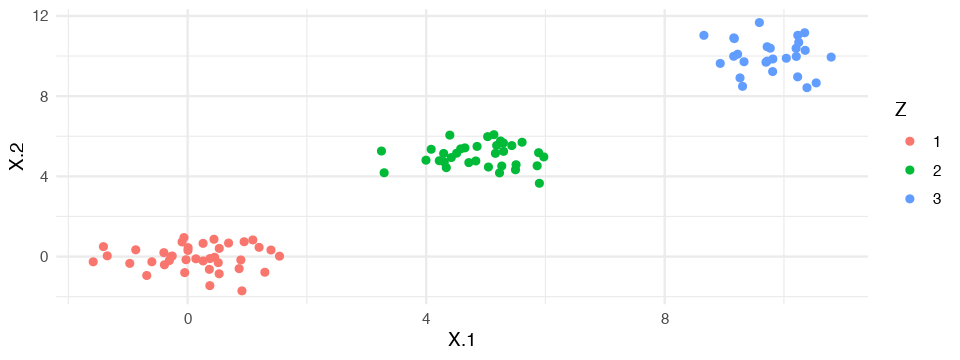

In [5]:
data.frame(X=X, Z=as.factor(Z)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()

Function to compute the update of the covariance matrix, We will only need that for the M-step.

In [6]:
.cov <- function(n, r, X, m, N.k)
{
  (t(r * (X - m))  %*%  ((X - m))) / N.k
}

Initialization of the parameters to be inferred.

In [7]:
pi.est <- rdirichlet(1, c(1, 1, 1))
mu.est <- matrix(c(0, 5, 10, 0, 5, 10), ncol = 2)
sigma.est <- array(0, dim = c(K, p, p))
for (i in (seq(K))) sigma.est[i, , ] <- diag(p)

And the EM-algorithm.

In [8]:
for (idx in seq(50))
{
    ### E step
    re <- sapply(seq(K), function(i) {
      pi.est[i] *  mvtnorm::dmvnorm(X, mu.est[i,], sigma.est[i,,])
    })
    r <- apply(re, 1, sum)
    rs <- re / r
    N.k <- apply(rs, 2, sum)

    ### M step
    for (i in seq(K)) {
        mu.est[i,] <- apply(rs[ ,i] * X, 2, sum) / N.k[i] 
        sigma.est[i,,] <- .cov(n, rs[ ,i], X, mu.est[i,], N.k[i])
    }    
}               

Now let's assign the data to their mosty likely classes.

In [9]:
probs <- data.frame(
    Z1 = mvtnorm::dmvnorm(X, mu.est[1,], sigma.est[1,,]),
    Z2 = mvtnorm::dmvnorm(X, mu.est[2,], sigma.est[2,,]),
    Z3 = mvtnorm::dmvnorm(X, mu.est[3,], sigma.est[3,,]))
zs.est <- apply(probs, 1, which.max)

Then we plot what we found.

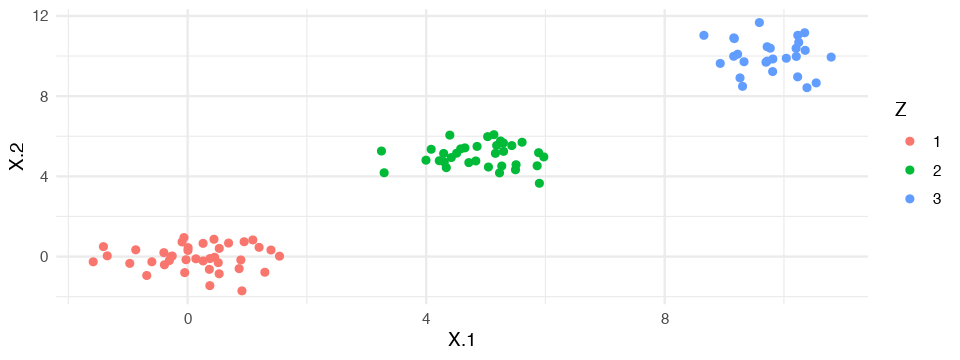

In [10]:
# initialization of the cluster assignments
data.frame(X=X, Z=as.factor(zs.est)) %>%
    ggplot() +
    geom_point(aes(X.1, X.2, col=Z)) +
    theme_minimal()